# Hard Voting

This notebook implements the voting classifier, an ensemble method that trains various models and makes predictions based on aggregating these base estimators.

---

First, load the relevant libraries needed.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import a nice function for plotting decision boundaries
from mlxtend.plotting import plot_decision_regions

# Set the Seaborn theme
sns.set_theme()

# Import functions to help with training/testing endeavors and evaluate performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from mlxtend.evaluate import bias_variance_decomp

# Import classification models to perform voting with
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

# surpress deprecation warnings, such as those from KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore') 

## The Data

The model will be trained using the [Hawks](https://github.com/kary5678/INDE-577/blob/main/Data/hawks.csv) dataset. This dataset contains observations for three species of hawks, and attributes such as age, sex, wing length, body weight, tail length, etc. 

The code block below reads the dataset into a pandas DataFrame object, subsets the DataFrame to the relevant variables, and drops any rows where there are missing values for these relevant variables.

In [2]:
# Read in the data and subset it to the relevant columns/observations
hawks = pd.read_csv("../../../Data/hawks.csv")
hawks = hawks[["Species", "Wing", "Tail", "Weight", "Culmen", "Hallux"]].dropna(axis=0)
hawks

,Species,Wing,Tail,Weight,Culmen,Hallux
0,RT,385.0,219,920.0,25.7,30.1
2,RT,381.0,235,990.0,26.7,31.3
3,CH,265.0,220,470.0,18.7,23.5
4,SS,205.0,157,170.0,12.5,14.3
5,RT,412.0,230,1090.0,28.5,32.2
...,...,...,...,...,...,...
903,RT,380.0,224,1525.0,26.0,27.6
904,SS,190.0,150,175.0,12.7,15.4
905,RT,360.0,211,790.0,21.9,27.6
906,RT,369.0,207,860.0,25.2,28.0


## Model 1: Binary Classification w/ Perceptron, kNN, Decision Tree

I will be using scikit-learn to fit all the models of interest. First, I split the dataset into training and testing observations.

The processed data is randomly split into a training and testing set using the traditional 80-20 rule of the Pareto Principle. The parameter `random_state=1` is used to ensure that we get the same observations in the training/testing set as in the Hawks exploratory analysis notebook [here](https://github.com/kary5678/INDE-577/blob/main/Data/hawks_analysis.ipynb). We know from the plots in `hawks_analysis.ipynb` that the split using this `random_state` produces a training set that is a good representation for the data being tested (and vice versa). This is also the split that I've used to fit all the models involved.

For this first voting model, the goal is binary classification, and I'm going to include 3 different models: the perceptron, kNN, and the decision tree. By including these 3 different models of different strengths and weaknesses, I hope to improve overall predictive performance.

In [3]:
# Data preparation step
X = hawks[["Wing", "Tail"]].to_numpy()
# Convert each entry of y with RT (red-tailed) to -1 and otherwise 1
hawks["Species_binary"] = [1 if x == "RT" else -1 for x in hawks.Species]
y = hawks["Species_binary"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

### Obtain the perceptron model

First, find the best model under different learning rates.

In [4]:
learning_rates = [0.5, 0.25, 0.1, 0.01, 0.001, 0.0001, 0.00001]
for eta in learning_rates:
    per_model = Perceptron(eta0 = eta, max_iter = 5000, random_state = 42)
    per_model.fit(X_train, y_train)
    print(f"rate = {eta}: {per_model.score(X_train, y_train)}")

rate = 0.5: 0.9353932584269663
rate = 0.25: 0.9353932584269663
rate = 0.1: 0.9353932584269663
rate = 0.01: 0.9353932584269663
rate = 0.001: 0.9353932584269663
rate = 0.0001: 0.9353932584269663
rate = 1e-05: 0.9353932584269663


No differences in training accuracy under different learning rates, so I'll just use 0.0001.

In [5]:
per_model = Perceptron(eta0 = 0.0001, max_iter = 5000, random_state = 42)
per_model.fit(X_train, y_train)

print("Training accuracy:", per_model.score(X_train, y_train))
print("Testing accuracy:", per_model.score(X_test, y_test))

Training accuracy: 0.9353932584269663
Testing accuracy: 0.9441340782122905


In [6]:
y_pred_per = per_model.predict(X_test)
print(classification_report(y_test, y_pred_per))

              precision    recall  f1-score   support

          -1       1.00      0.86      0.93        73
           1       0.91      1.00      0.95       106

    accuracy                           0.94       179
   macro avg       0.96      0.93      0.94       179
weighted avg       0.95      0.94      0.94       179



The perceptron model for binary classification has good accuracy. In terms of precision/recall, it does not do bad either. I will perform a more thorough inspection of this through a confusion matrix.

In [7]:
def plot_RT_confusion_matrix(y_actual, y_pred):
    """
    Plots the confusion matrix given the actual and predicted values
    to easily view accurate classifications and type I/II errors
    """             
    classes = [1, -1] # want to invert the order of the classes in outputted matrix
    # Obtain confusion matrix
    cf_matrix = confusion_matrix(y_actual, y_pred, labels=[1, -1])

    # View the confusion matrix using the seaborn package
    plt.figure(figsize = (6, 4))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Hawk Species Classification Confusion Matrix\n', fontsize = 14)
    ax.set_xlabel('\nPredicted Values', fontsize = 12)
    ax.set_ylabel('Actual Values ', fontsize = 12)
    ax.xaxis.set_ticklabels(["RT", "Not RT"])
    ax.yaxis.set_ticklabels(["RT", "Not RT"])

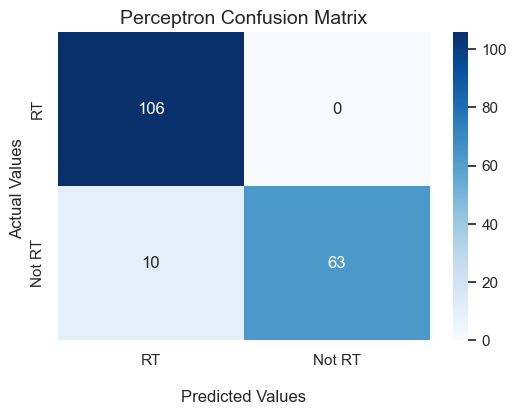

In [8]:
plot_RT_confusion_matrix(y_test, y_pred_per)
plt.title("Perceptron Confusion Matrix", fontsize = 14)
plt.show()

Based on the confusion matrix, the perceptron does well. I note that there are 10 false positive cases where the model predicts that a hawk is red-tailed when they are not. Therefore, it would be good to include a model in the voting classifier that has a lower false positive rate.

### Obtain kNN model

First, I need to find the optimal value of k to use.

In [9]:
def plot_knn_accuracies(X_train, y_train):
    """
    For a range of k, find the training accuracy of a kNN model and plot it
    """
    knn_accuracy = []
    possible_k = range(3, 16)
    for k in possible_k:
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train, y_train)
        knn_accuracy.append(knn.score(X_train, y_train))

    plt.figure(figsize = (6, 4))
    plt.plot(possible_k, knn_accuracy, color = 'red', marker = "o")
    plt.title("Training Accuracy of kNN under different k", fontsize = 14)
    plt.xlabel('k', fontsize = 14)
    plt.ylabel('Classification Accuracy', fontsize = 14)
    plt.xticks(possible_k)

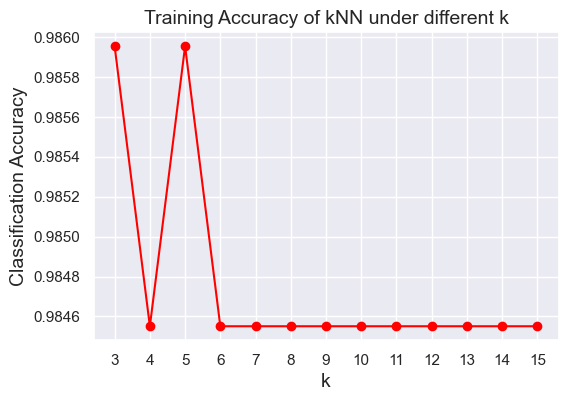

In [10]:
plot_knn_accuracies(X_train, y_train)
plt.show()

Based on the plot above, to maximize model accuracy while not keeping the model too complex by overfitting (low values of $k$), I will proceed by choosing 5 for $k$.

In [11]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

print("Training accuracy:", knn.score(X_train, y_train))
print("Testing accuracy:", knn.score(X_test, y_test))

Training accuracy: 0.9859550561797753
Testing accuracy: 0.9888268156424581


In [12]:
y_pred_knn = knn.predict(X_test)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

          -1       1.00      0.97      0.99        73
           1       0.98      1.00      0.99       106

    accuracy                           0.99       179
   macro avg       0.99      0.99      0.99       179
weighted avg       0.99      0.99      0.99       179



Accuracy, precision, and recall of this kNN model is very high, much better than that of the perceptron.

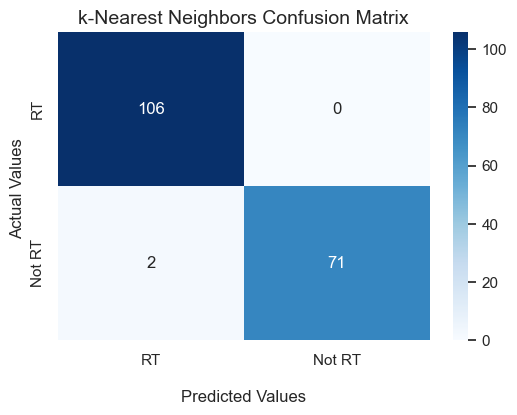

In [13]:
plot_RT_confusion_matrix(y_test, y_pred_knn)
plt.title("k-Nearest Neighbors Confusion Matrix", fontsize = 14)
plt.show()

Compared to the perceptron model, kNN's accuracy is higher. There are still no false negatives, and the false positive rate has decreased to 2 from 10. Including this model alongside the perceptron would clearly improve the prediction performance overall compared to just the perceptron by itself.

### Obtain decision tree model

To determine what `max_depth` to proceed with for my data, I iterate over a range of depths and evaluate the training accuracy at each depth. In general, as the depth increases, the training accuracy will increase and then eventually plataeu after being too complex and overfitting the training data. To provide additional insights, I will also factor in the testing data and evaluate the bias-variance breakdown at each depth as well. As the depth increases, the bias of the decision tree will decrease, while the variance would increase. A model with high bias and low variance may underfit the data, while a model with low bias and high variance may overfit the data.

In [14]:
def plot_tree_performance(X_train, y_train, X_test, y_test):
    """
    Obtain diagnostic plots of the decision tree model's performance over a range of max_depths from 2-20.
    There are two plots: one displaying training accuracy and the other displaying bias/variance.
    This function is meant to help diagnose the best max_depth for a decision tree model for the data.
    """
    # Obtain the accuracy and bias/variance for each Decision Tree to select the best depth
    tree_accuracy = []
    biases = []
    variances = []
    possible_depth = range(2, 21)
    for d in possible_depth:
        tree_model = DecisionTreeClassifier(max_depth = d, random_state = 42)
        tree_model.fit(X_train, y_train)
        # Obtain the training accuracy of the current decision tree
        tree_accuracy.append(tree_model.score(X_train, y_train))
        # Obtain bias/variance decomposition for the current decision tree
        _, bias, var = bias_variance_decomp(tree_model,
            X_train, y_train, X_test, y_test, loss = 'mse', random_seed = 123)
        biases.append(bias)
        variances.append(var)
    
    # Plot the training accuracy figure on the left
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
    ax1.plot(possible_depth, tree_accuracy, color = 'red', marker = "o")
    ax1.set_title("Training Accuracy of Decision Tree under different depths", fontsize = 14)
    ax1.set_xlabel('Maximum depth', fontsize = 14)
    ax1.set_ylabel('Classification Accuracy', fontsize = 14)
    ax1.set_xticks(possible_depth)
    # Plot the bias/variance figure on the right
    ax2.plot(possible_depth, biases, color = 'blue', marker = "o", label = "Bias")
    ax2.plot(possible_depth, variances, color = 'orange', marker = "o", label = "Variance")
    ax2.set_title("Bias/Variance of Decision Tree under different depths", fontsize = 14)
    ax2.set_xlabel('Maximum depth', fontsize = 14)
    ax2.set_xticks(possible_depth)
    ax2.legend(loc = "lower right")

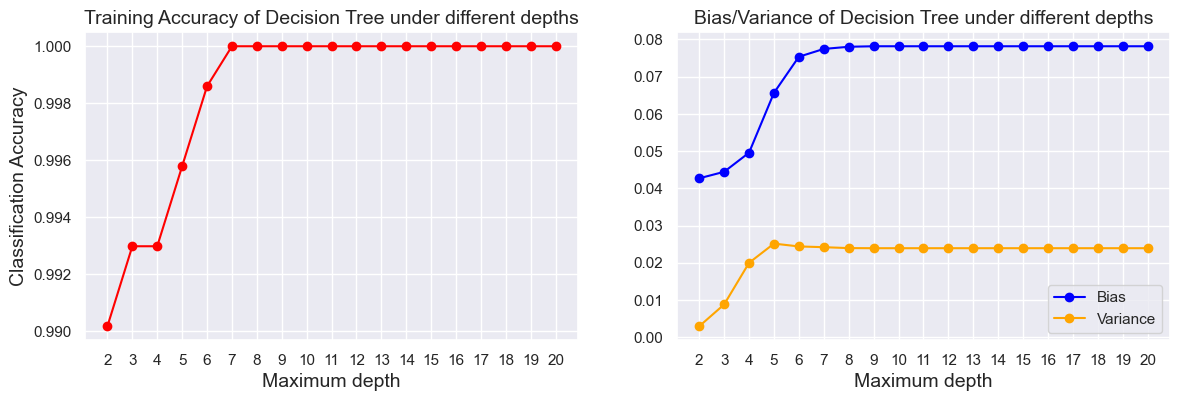

In [15]:
plot_tree_performance(X_train, y_train, X_test, y_test)
plt.show()

Examination of the plots above suggest a `max_depth` of 5 would be optimal, by balancing training accuracy and bias/variance tradeoff in a way that there is not overfitting.

In [16]:
decision_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
decision_tree.fit(X_train, y_train)

print("Training accuracy:", decision_tree.score(X_train, y_train))
print("Testing accuracy:", decision_tree.score(X_test, y_test))

Training accuracy: 0.9957865168539326
Testing accuracy: 0.9720670391061452


In [17]:
y_pred_tree = decision_tree.predict(X_test)
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

          -1       0.99      0.95      0.97        73
           1       0.96      0.99      0.98       106

    accuracy                           0.97       179
   macro avg       0.97      0.97      0.97       179
weighted avg       0.97      0.97      0.97       179



This model also has high accuracy, precision, and recall, although it doesn't necessarily do as well as the kNN model.

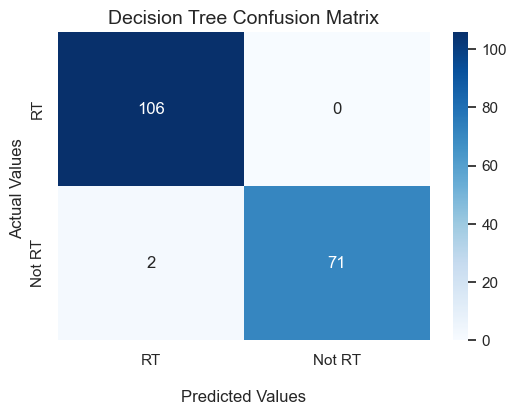

In [18]:
plot_RT_confusion_matrix(y_test, y_pred_knn)
plt.title("Decision Tree Confusion Matrix", fontsize = 14)
plt.show()

Based on the confusion matrix, the decision tree performs better than the perceptron in terms of misclassifications, and has only one false positive case more than the kNN. Keeping the performance of these 3 different models in mind, I wonder how the voting classifier will aggregate these models and perform.

### Aggregate the models to perform voting

In [19]:
voting_model = VotingClassifier(estimators=[
    ('per', per_model), ('knn', knn), ('tree', decision_tree)])
voting_model.fit(X_train, y_train)

print("Training accuracy:", voting_model.score(X_train, y_train))
print("Testing accuracy:", voting_model.score(X_test, y_test))

Training accuracy: 0.9887640449438202
Testing accuracy: 0.9888268156424581


In [20]:
y_pred_voting = voting_model.predict(X_test)
print(classification_report(y_test, y_pred_voting))

              precision    recall  f1-score   support

          -1       1.00      0.97      0.99        73
           1       0.98      1.00      0.99       106

    accuracy                           0.99       179
   macro avg       0.99      0.99      0.99       179
weighted avg       0.99      0.99      0.99       179



Accuracy, precision, and recall wise, the voting model has taken these 3 models and aggregated them in such a way that it performs just as well. While it doesn't necessarily beat the kNN algorithm numbers wise, the aggregation makes the model more robust, which is meritorious.

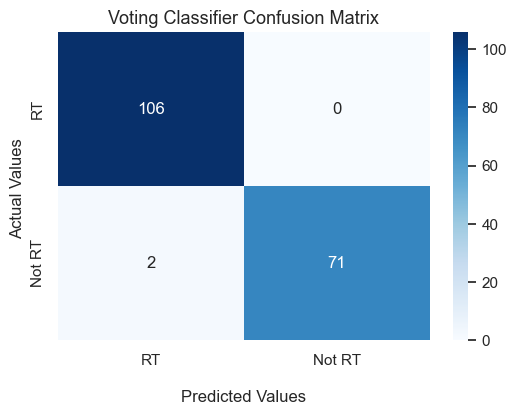

In [21]:
plot_RT_confusion_matrix(y_test, y_pred_voting)
plt.title("Voting Classifier Confusion Matrix", fontsize = 13)
plt.show()

Examination of the confusion matrix confirms this finding. This confusion matrix looks like the one for kNN; we've minimized the classification errors based on the 3 inputted models!

## Model 2: Species Classification With kNN & Decision Trees

In the previous model, I combined 3 different algorithms to perform binary classification using the voting classifier. Now, I will perform classification for my 3 species classes. This time, I will also play with using the same algorithm, but training with a different subset of the data or different hyperparameters.

In my notebook for decision trees, I found that a 5 predictor decision tree performed better than a 2 predictor one (although technically the 5 predictor decision tree uses only 2 predictors in its decision criterions). Using this information, I will include both of these models in my voting classifier along with kNN for fun and evaluate the result.

In [22]:
# Data preparation step
y2 = hawks["Species"].to_numpy()

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size=0.20, random_state=1)

### Obtain kNN model

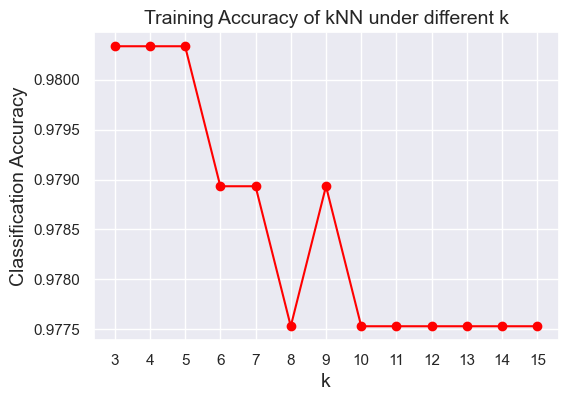

In [23]:
plot_knn_accuracies(X_train2, y_train2)
plt.show()

The optimal $k$ to use in this case is also 5, to maximize accuracy while not becoming a too overfit model.

In [24]:
knn2 = KNeighborsClassifier(n_neighbors = 5)
knn2.fit(X_train2, y_train2)

print("Training accuracy:", knn2.score(X_train2, y_train2))
print("Testing accuracy:", knn2.score(X_test2, y_test2))

Training accuracy: 0.9803370786516854
Testing accuracy: 0.9776536312849162


In [25]:
y_pred_knn2 = knn2.predict(X_test2)
print(classification_report(y_test2, y_pred_knn2))

              precision    recall  f1-score   support

          CH       0.92      0.85      0.88        13
          RT       0.98      1.00      0.99       106
          SS       0.98      0.97      0.97        60

    accuracy                           0.98       179
   macro avg       0.96      0.94      0.95       179
weighted avg       0.98      0.98      0.98       179



This kNN model has high accuracy; it is a good fit for the data. But can we do better?

Let's also look at the confusion matrix for specifics.

In [26]:
def plot_hawk_confusion_matrix(y_actual, y_pred):
    """
    Plots the confusion matrix given the actual and predicted values
    to easily view accurate classifications and type I/II errors
    """             
    # Obtain confusion matrix
    classes = ["RT", "CH", "SS"]
    cf_matrix = confusion_matrix(y_actual, y_pred, labels = classes)

    # View the confusion matrix using the seaborn package
    plt.figure(figsize = (6, 4))
    ax = sns.heatmap(cf_matrix, annot = True, cmap = 'Blues', fmt = 'g')
    ax.set_title('Confusion Matrix\n', fontsize = 14)
    ax.set_xlabel("Predicted Label", fontsize = 12)
    ax.set_xticklabels(classes)
    ax.set_ylabel("True Label", fontsize = 12)
    ax.set_yticklabels(classes, rotation = 0)

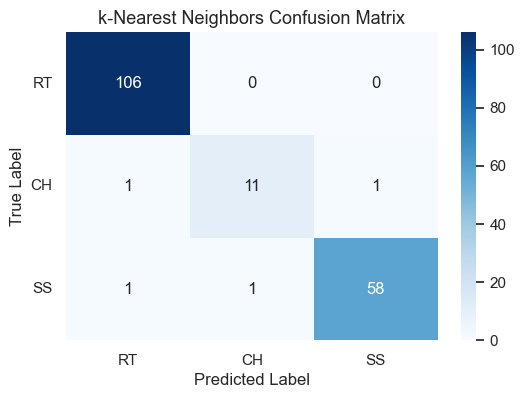

In [27]:
plot_hawk_confusion_matrix(y_test2, y_pred_knn2)
plt.title("k-Nearest Neighbors Confusion Matrix", fontsize = 13)
plt.show()

The kNN model has trouble correctly classifying some of the minority classes.

### Obtain 1st decision tree model

Now, I will fit the decision tree using 2 predictors using `max_depth=3` as I found in my [decision trees notebook](https://github.com/kary5678/INDE-577/blob/main/supervised-learning/decision_trees/decision_trees.ipynb).

In [28]:
decision_tree2 = DecisionTreeClassifier(max_depth=3, random_state=42)
decision_tree2.fit(X_train2, y_train2)

print("Training accuracy:", decision_tree2.score(X_train2, y_train2))
print("Testing accuracy:", decision_tree2.score(X_test2, y_test2))

Training accuracy: 0.9859550561797753
Testing accuracy: 0.9720670391061452


In [29]:
y_pred_tree2 = decision_tree2.predict(X_test2)
print(classification_report(y_test2, y_pred_tree2))

              precision    recall  f1-score   support

          CH       0.91      0.77      0.83        13
          RT       0.97      1.00      0.99       106
          SS       0.98      0.97      0.97        60

    accuracy                           0.97       179
   macro avg       0.95      0.91      0.93       179
weighted avg       0.97      0.97      0.97       179



Accuracy is high in this model but overall it does not perform better than kNN.

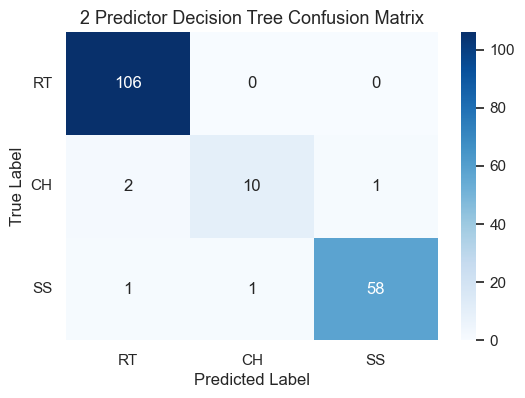

In [30]:
plot_hawk_confusion_matrix(y_test2, y_pred_tree2)
plt.title("2 Predictor Decision Tree Confusion Matrix", fontsize = 13)
plt.show()

Based on this confusion matrix, this model has an additional misclassification of one Cooper's hawk compared to in kNN.

### Obtain 2nd decision tree model

Now, I will fit the decision tree using 5 predictors using `max_depth=3` as I found in my [decision trees notebook](https://github.com/kary5678/INDE-577/blob/main/supervised-learning/decision_trees/decision_trees.ipynb).


In [31]:
X3 = hawks[["Wing", "Tail", "Weight", "Hallux", "Culmen"]].to_numpy()
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y2, test_size=0.20, random_state=1)

decision_tree3 = DecisionTreeClassifier(max_depth=3, random_state=42)
decision_tree3.fit(X_train3, y_train3)

print("Training accuracy:", decision_tree3.score(X_train3, y_train3))
print("Testing accuracy:", decision_tree3.score(X_test3, y_test3))

Training accuracy: 0.9943820224719101
Testing accuracy: 0.9776536312849162


In [32]:
y_pred_tree3 = decision_tree3.predict(X_test3)
print(classification_report(y_test3, y_pred_tree3))

              precision    recall  f1-score   support

          CH       0.92      0.85      0.88        13
          RT       0.99      1.00      1.00       106
          SS       0.97      0.97      0.97        60

    accuracy                           0.98       179
   macro avg       0.96      0.94      0.95       179
weighted avg       0.98      0.98      0.98       179



This decision tree has higher accuracy/precision/recall than the previous. Based on the confusion matrix below, it has fewer misclassifications too!

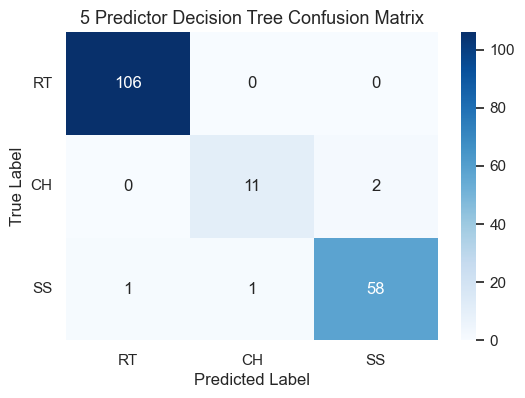

In [33]:
plot_hawk_confusion_matrix(y_test3, y_pred_tree3)
plt.title("5 Predictor Decision Tree Confusion Matrix", fontsize = 13)
plt.show()

### Aggregate the models to perform voting

In [34]:
voting_model2 = VotingClassifier(estimators=[
    ("knn2", knn2), ("tree2", decision_tree2), ("tree3", decision_tree3)])
voting_model2.fit(X_train2, y_train2)

print("Training accuracy:", voting_model2.score(X_train2, y_train2))
print("Testing accuracy:", voting_model2.score(X_test2, y_test2))

Training accuracy: 0.9859550561797753
Testing accuracy: 0.9720670391061452


In [35]:
y_pred_voting2 = voting_model2.predict(X_test2)
print(classification_report(y_test2, y_pred_voting2))

              precision    recall  f1-score   support

          CH       0.91      0.77      0.83        13
          RT       0.97      1.00      0.99       106
          SS       0.98      0.97      0.97        60

    accuracy                           0.97       179
   macro avg       0.95      0.91      0.93       179
weighted avg       0.97      0.97      0.97       179



I note that the recall for the CH species in the voting model is less than in the other models but otherwise, the voting model takes the best of each model and improves the overall species prediction performance.

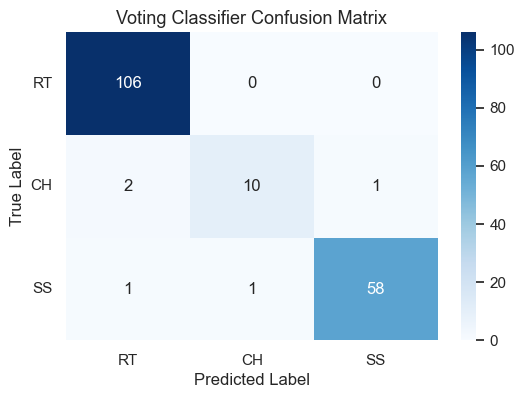

In [36]:
plot_hawk_confusion_matrix(y_test2, y_pred_voting2)
plt.title("Voting Classifier Confusion Matrix", fontsize = 13)
plt.show()

## Concluding Remarks

While the results weren't necessarily significant, voting as an ensemble method is able to improve predictive performance through aggregation of multiple models. I explored voting models involving different individual algorithms and different data subsets. Other ways to perform voting are with different hyperparameters.

While the overall model at the end is more complex than an individual model is, the aggregation creates a more robust model for the data!